### Just checking the directories if the dataset is present or not

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dataset-object-classification/data_batch_1
/kaggle/input/dataset-object-classification/data_batch_2
/kaggle/input/dataset-object-classification/batches.meta
/kaggle/input/dataset-object-classification/test_batch
/kaggle/input/dataset-object-classification/data_batch_3
/kaggle/input/dataset-object-classification/data_batch_5
/kaggle/input/dataset-object-classification/data_batch_4
/kaggle/input/dataset-object-classification/readme.html


### Importing necessary libraries

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Function to load CIFAR-10 btach files

In [3]:
def unpickle(file_path):
    with open(file_path, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        return dict

In [3]:
meta = unpickle(os.path.join("/kaggle/input/dataset-object-classification/", "batches.meta"))

label_names = []
for name in meta[b'label_names']:
    label_names.append(name.decode('utf-8'))
print("CIFAR-10 classes: ", label_names)

CIFAR-10 classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Custom Dataset for raw CIFAR-10 files (batch files in pickle format)

In [4]:
class CIFAR10Raw(Dataset):

    # load all images & labels into memory
    def __init__(self, batch_files, transform=None):
        all_data, all_labels = [], []

        for bf in batch_files:
            batch = unpickle(bf)
            all_data.append(batch[b'data']) # shape: (N, 3072)
            all_labels.extend(batch[b'labels'])  # list of length N

        # Reshape and transpose to get (N, 3, 32, 32)
        self.data = np.vstack(all_data).reshape(-1, 3, 32, 32).astype(np.uint8)
        self.labels = np.array(all_labels, dtype=np.int64)
        self.transform = transform

    # total number of samples
    def __len__(self):
        return len(self.labels)

    # return (image, label) at index idx
    def __getitem__(self, idx):
        img = self.data[idx]
        img = torch.tensor(img, dtype=torch.uint8)
    
        if self.transform:
            img = self.transform(img)
        else:
            img = img.float() / 255.0

        label = int(self.labels[idx])

        return img, torch.tensor(label, dtype=torch.long) 

### A simple convolutional neural network for CIFAR-10 classification.

In [5]:
# new class inheriting from nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__() # call parent class constructor via super()

        self.block1 = nn.Sequential(
            # Convolution: 3→32 feature maps, 3×3 kernels, same spatial size.
            # in_channels=3 because input is RGB image
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 2D convolution layer
            nn.ReLU(inplace=True), # Applies ReLU nonlinearity in-place for efficiency.
            nn.MaxPool2d(kernel_size=2), # max-pool layer with window size 2×2, Downsamples by 2×2, halving height & width.
            nn.Dropout(p=0.25), # Randomly zeroes 25% of activations to prevent overfitting.
        )

        self.block2 = nn.Sequential(
            # Convolution: 32→64 feature maps, 3×3 kernels, same spatial size
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25), # 25% dropout for regularization.
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), # Flattens 3D feature map (64×8×8 → 4096) into 1D vector.
            nn.Linear(in_features=64 * 8 * 8, out_features=512), # Fully-connected: 4096 inputs → 512 hidden units.
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5), # 50% dropout to further regularize.
            nn.Linear(in_features=512, out_features=10) # 	Final FC: 512 → 10 logits (one per class).
        )

    def forward(self, x):
        x = self.block1(x) # Apply Block1 conv→ReLU→pool→dropout.
        x = self.block2(x) # Apply Block2 conv→ReLU→pool→dropout.
        x = self.classifier(x) # Flatten → FC→ReLU→dropout → final FC.

        return x # Output raw class scores (logits).

In [6]:
# Directory where CIFAR-10 batch files are stored
DATA_DIR = '/kaggle/input/dataset-object-classification/'

# Locate all training batch files and the test batch file
train_files = sorted(glob(os.path.join(DATA_DIR, "data_batch_*")))
test_files = [os.path.join(DATA_DIR, "test_batch")]

In [7]:
# Channel-wise mean and std (precomputed)
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

# Defining transformations for training and testing
transform_train = transforms.Compose([ # Chains multiple transforms into one callable.
    transforms.ToPILImage(), # Converts a NumPy array or tensor (C×H×W) back into a PIL Image so that PIL-based ops (e.g. flips) work.
    transforms.RandomHorizontalFlip(), # With 50% probability, flips the image left↔right. Adds data-augmentation by showing mirrored examples.
    transforms.ToTensor(), # Converts the PIL Image to a FloatTensor of shape (C×H×W), scaling pixel values from [0,255] → [0.0,1.0].
    transforms.Normalize(mean, std) # 	For each channel, subtracts the mean and divides by std (i.e. (x - mean)/std), standardizing inputs.
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [8]:
 # Create Dataset and DataLoader for training and testing
train_ds = CIFAR10Raw(train_files, transform=transform_train)
test_ds = CIFAR10Raw(test_files, transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [9]:
# Setting up the decvice 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize model, loss, and optimizer
model = SimpleCNN().to(device) # instantiate model, .to(device) moves it to CPU/GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [10]:
# Runs n epochs: forward pass → compute loss → backprop → update weights → print loss each epoch.
epochs = 50

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad() # clear accumulated gradients
        out = model(imgs) # call model’s forward
        loss = criterion(out, labels) # compute loss value
        loss.backward() # backpropagate gradients
        optimizer.step() # update weights
        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} - Average Training Loss: {avg_loss:.4f}")


Epoch 1/50: 100%|██████████| 391/391 [00:17<00:00, 22.61it/s]


Epoch 1 - Average Training Loss: 1.5117


Epoch 2/50: 100%|██████████| 391/391 [00:16<00:00, 24.20it/s]


Epoch 2 - Average Training Loss: 1.1682


Epoch 3/50: 100%|██████████| 391/391 [00:16<00:00, 24.04it/s]


Epoch 3 - Average Training Loss: 1.0453


Epoch 4/50: 100%|██████████| 391/391 [00:16<00:00, 24.14it/s]


Epoch 4 - Average Training Loss: 0.9700


Epoch 5/50: 100%|██████████| 391/391 [00:16<00:00, 24.25it/s]


Epoch 5 - Average Training Loss: 0.9166


Epoch 6/50: 100%|██████████| 391/391 [00:16<00:00, 23.90it/s]


Epoch 6 - Average Training Loss: 0.8716


Epoch 7/50: 100%|██████████| 391/391 [00:16<00:00, 23.92it/s]


Epoch 7 - Average Training Loss: 0.8397


Epoch 8/50: 100%|██████████| 391/391 [00:16<00:00, 24.25it/s]


Epoch 8 - Average Training Loss: 0.8118


Epoch 9/50: 100%|██████████| 391/391 [00:16<00:00, 24.33it/s]


Epoch 9 - Average Training Loss: 0.7864


Epoch 10/50: 100%|██████████| 391/391 [00:16<00:00, 24.20it/s]


Epoch 10 - Average Training Loss: 0.7598


Epoch 11/50: 100%|██████████| 391/391 [00:16<00:00, 24.11it/s]


Epoch 11 - Average Training Loss: 0.7464


Epoch 12/50: 100%|██████████| 391/391 [00:16<00:00, 24.05it/s]


Epoch 12 - Average Training Loss: 0.7258


Epoch 13/50: 100%|██████████| 391/391 [00:15<00:00, 24.52it/s]


Epoch 13 - Average Training Loss: 0.7148


Epoch 14/50: 100%|██████████| 391/391 [00:16<00:00, 24.24it/s]


Epoch 14 - Average Training Loss: 0.7000


Epoch 15/50: 100%|██████████| 391/391 [00:15<00:00, 24.53it/s]


Epoch 15 - Average Training Loss: 0.6840


Epoch 16/50: 100%|██████████| 391/391 [00:16<00:00, 24.41it/s]


Epoch 16 - Average Training Loss: 0.6696


Epoch 17/50: 100%|██████████| 391/391 [00:15<00:00, 24.46it/s]


Epoch 17 - Average Training Loss: 0.6608


Epoch 18/50: 100%|██████████| 391/391 [00:16<00:00, 24.19it/s]


Epoch 18 - Average Training Loss: 0.6480


Epoch 19/50: 100%|██████████| 391/391 [00:16<00:00, 24.29it/s]


Epoch 19 - Average Training Loss: 0.6367


Epoch 20/50: 100%|██████████| 391/391 [00:16<00:00, 24.13it/s]


Epoch 20 - Average Training Loss: 0.6382


Epoch 21/50: 100%|██████████| 391/391 [00:16<00:00, 24.21it/s]


Epoch 21 - Average Training Loss: 0.6160


Epoch 22/50: 100%|██████████| 391/391 [00:16<00:00, 24.16it/s]


Epoch 22 - Average Training Loss: 0.6198


Epoch 23/50: 100%|██████████| 391/391 [00:15<00:00, 24.74it/s]


Epoch 23 - Average Training Loss: 0.6092


Epoch 24/50: 100%|██████████| 391/391 [00:15<00:00, 24.55it/s]


Epoch 24 - Average Training Loss: 0.5982


Epoch 25/50: 100%|██████████| 391/391 [00:15<00:00, 24.55it/s]


Epoch 25 - Average Training Loss: 0.5946


Epoch 26/50: 100%|██████████| 391/391 [00:15<00:00, 24.51it/s]


Epoch 26 - Average Training Loss: 0.5890


Epoch 27/50: 100%|██████████| 391/391 [00:15<00:00, 24.49it/s]


Epoch 27 - Average Training Loss: 0.5777


Epoch 28/50: 100%|██████████| 391/391 [00:15<00:00, 24.53it/s]


Epoch 28 - Average Training Loss: 0.5755


Epoch 29/50: 100%|██████████| 391/391 [00:15<00:00, 24.58it/s]


Epoch 29 - Average Training Loss: 0.5660


Epoch 30/50: 100%|██████████| 391/391 [00:15<00:00, 24.70it/s]


Epoch 30 - Average Training Loss: 0.5583


Epoch 31/50: 100%|██████████| 391/391 [00:15<00:00, 24.66it/s]


Epoch 31 - Average Training Loss: 0.5506


Epoch 32/50: 100%|██████████| 391/391 [00:15<00:00, 24.76it/s]


Epoch 32 - Average Training Loss: 0.5517


Epoch 33/50: 100%|██████████| 391/391 [00:15<00:00, 25.06it/s]


Epoch 33 - Average Training Loss: 0.5439


Epoch 34/50: 100%|██████████| 391/391 [00:15<00:00, 24.71it/s]


Epoch 34 - Average Training Loss: 0.5451


Epoch 35/50: 100%|██████████| 391/391 [00:15<00:00, 24.92it/s]


Epoch 35 - Average Training Loss: 0.5335


Epoch 36/50: 100%|██████████| 391/391 [00:15<00:00, 24.83it/s]


Epoch 36 - Average Training Loss: 0.5303


Epoch 37/50: 100%|██████████| 391/391 [00:15<00:00, 24.98it/s]


Epoch 37 - Average Training Loss: 0.5263


Epoch 38/50: 100%|██████████| 391/391 [00:15<00:00, 24.86it/s]


Epoch 38 - Average Training Loss: 0.5207


Epoch 39/50: 100%|██████████| 391/391 [00:15<00:00, 24.97it/s]


Epoch 39 - Average Training Loss: 0.5194


Epoch 40/50: 100%|██████████| 391/391 [00:15<00:00, 24.90it/s]


Epoch 40 - Average Training Loss: 0.5203


Epoch 41/50: 100%|██████████| 391/391 [00:15<00:00, 24.82it/s]


Epoch 41 - Average Training Loss: 0.5155


Epoch 42/50: 100%|██████████| 391/391 [00:15<00:00, 24.96it/s]


Epoch 42 - Average Training Loss: 0.5005


Epoch 43/50: 100%|██████████| 391/391 [00:15<00:00, 24.80it/s]


Epoch 43 - Average Training Loss: 0.5060


Epoch 44/50: 100%|██████████| 391/391 [00:15<00:00, 24.72it/s]


Epoch 44 - Average Training Loss: 0.5011


Epoch 45/50: 100%|██████████| 391/391 [00:15<00:00, 24.84it/s]


Epoch 45 - Average Training Loss: 0.4988


Epoch 46/50: 100%|██████████| 391/391 [00:15<00:00, 24.74it/s]


Epoch 46 - Average Training Loss: 0.4961


Epoch 47/50: 100%|██████████| 391/391 [00:15<00:00, 24.91it/s]


Epoch 47 - Average Training Loss: 0.4952


Epoch 48/50: 100%|██████████| 391/391 [00:15<00:00, 24.87it/s]


Epoch 48 - Average Training Loss: 0.4874


Epoch 49/50: 100%|██████████| 391/391 [00:15<00:00, 24.85it/s]


Epoch 49 - Average Training Loss: 0.4838


Epoch 50/50: 100%|██████████| 391/391 [00:15<00:00, 24.49it/s]

Epoch 50 - Average Training Loss: 0.4814


In [11]:
# Evaluation on test set
# Disables grad, runs model on test set, counts correct predictions, and prints overall accuracy.
model.eval()
correct = 0
total = 0

with torch.no_grad(): # context manager disabling gradient tracking
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs) # forward pass

        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0) # .size(0): batch dimension size
        correct += (predicted == labels).sum().item() # element-wise comparison → boolean tensor → sum → int

test_acc = 100.0 * correct / total
print(f"Test accuracy: {test_acc:.2f}%")


Test accuracy: 79.61%


In [12]:
# Save the trained model's state dictionary
torch.save(model.state_dict(), 'simple_cnn_cifar10.pth')
print("Model saved to simple_cnn_cifar10.pth")

Model saved to simple_cnn_cifar10.pth


In [13]:
# Loading the model for inference later (optional)
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('simple_cnn_cifar10.pth'))
model.eval()

SimpleCNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

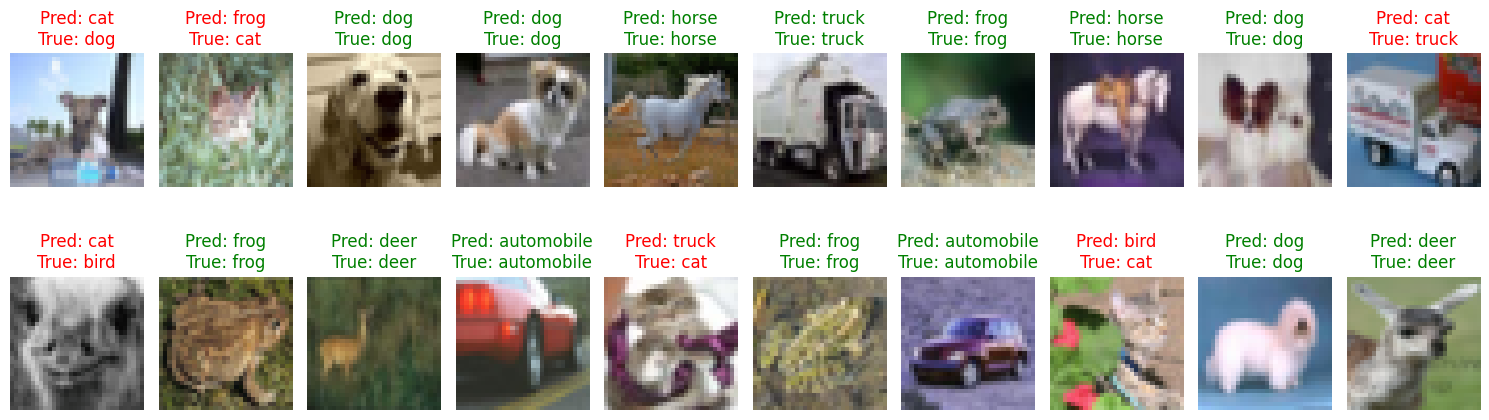

In [14]:
import matplotlib.pyplot as plt

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Show n test samples with predictions
def visualize_predictions(model, test_loader, device, num_samples=10):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)

            for i in range(imgs.size(0)):
                if images_shown >= num_samples:
                    break
                img = imgs[i].cpu()
                label = labels[i].item()
                pred = predicted[i].item()

                # Unnormalize the image for display
                img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
                img = img.permute(1, 2, 0).numpy()

                plt.subplot(2, num_samples // 2, images_shown + 1)
                plt.imshow(np.clip(img, 0, 1))
                plt.title(f"Pred: {classes[pred]}\nTrue: {classes[label]}", color="green" if pred == label else "red")
                plt.axis('off')

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_predictions(model, test_loader, device, num_samples=20)


In [18]:
# Just seeing the image size (just for reference)
d = unpickle('/kaggle/input/dataset-object-classification/data_batch_1')
data = np.vstack(d[b'data']).reshape(-1, 3, 32, 32).astype(np.uint8)
data

array([[[[ 59,  43,  50, ..., 158, 152, 148],
         [ 16,   0,  18, ..., 123, 119, 122],
         [ 25,  16,  49, ..., 118, 120, 109],
         ...,
         [208, 201, 198, ..., 160,  56,  53],
         [180, 173, 186, ..., 184,  97,  83],
         [177, 168, 179, ..., 216, 151, 123]],

        [[ 62,  46,  48, ..., 132, 125, 124],
         [ 20,   0,   8, ...,  88,  83,  87],
         [ 24,   7,  27, ...,  84,  84,  73],
         ...,
         [170, 153, 161, ..., 133,  31,  34],
         [139, 123, 144, ..., 148,  62,  53],
         [144, 129, 142, ..., 184, 118,  92]],

        [[ 63,  45,  43, ..., 108, 102, 103],
         [ 20,   0,   0, ...,  55,  50,  57],
         [ 21,   0,   8, ...,  50,  50,  42],
         ...,
         [ 96,  34,  26, ...,  70,   7,  20],
         [ 96,  42,  30, ...,  94,  34,  34],
         [116,  94,  87, ..., 140,  84,  72]]],


       [[[154, 126, 105, ...,  91,  87,  79],
         [140, 145, 125, ...,  96,  77,  71],
         [140, 139, 115, ..., 

### The `transforms.ToTensor()` operation in torchvision does three things, in order:

1. Data Type Conversion

- Takes an input image (either a PIL Image or a NumPy array with dtype uint8) and converts it to a PyTorch FloatTensor.

2. Shape Reordering

- If your input is H×W×C (height, width, channels), it permutes it to C×H×W, which is the format PyTorch models expect.

3. Value Scaling

- It divides every value by 255, so your pixels now lie in the continuous range [0.0, 1.0] instead of integers 0–255.

In [20]:
from torchvision import transforms
import numpy as np

# A 2×2 RGB image with uint8 pixels 0–255
dummy = np.array([[[  0,  64, 128],
                   [192, 255,   0]],
                 
                  [[ 32,  96, 160],
                   [224,   0,  32]]], dtype=np.uint8)

print("Shape (before conversion): ", dummy.shape)
tensor = transforms.ToTensor()(dummy)
print(tensor)
print("Shape (after conversion): ", tensor.shape)


Shape (before conversion):  (2, 2, 3)
tensor([[[0.0000, 0.7529],
         [0.1255, 0.8784]],

        [[0.2510, 1.0000],
         [0.3765, 0.0000]],

        [[0.5020, 0.0000],
         [0.6275, 0.1255]]])
Shape (after conversion):  torch.Size([3, 2, 2])
